In [1]:
# Imports
import tsne663 as t
import numpy as np
import data.data_utilities as util
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

**Contributors: Marc Brooks, Rob Kravec, Steven Winter**

# Abstract

We present a Python implementation of t-distributed stochastic neighbor embedding (t-SNE) based on van der Maaten and Hinton’s 2008 paper, “Visualizing Data using t-SNE.” Following background on dimensionality reduction and a thorough description of the t-SNE algorithm, we show that vectorization, just-in-time C compilation, and parallelization can reduce t-SNE run times by at least 99% compared to a naïve Python implementation. The most optimized version of the algorithm is then applied to simulated data with known underlying grouping structures to demonstrate (1) characteristic features of t-SNE, (2) the effect of the perplexity input on t-SNE results, and (3) the evolution of low-dimensional results as a function of t-SNE iteration number. These same attributes are then displayed by running t-SNE on real datasets with more complex geometries and higher numbers of underlying groups. Relative to two other methods of dimensionality reduction, PCA and Isomap, t-SNE delivers visualizations with superior clustering at the expense of run times that are 2-3 orders of magnitude longer. Lastly, Python package installation instructions are provided for those interested in reproducing the results in this report.

**Keywords:** Dimensionality Reduction, Visualization, Code Optimization, t-SNE, PCA, Isomap

# Background [1, 2]

In practice, high-dimensional data is often concentrated near a lower dimensional manifold. This can occur for a variety of reasons, but is commonly viewed as a signal that the underlying data-generating mechanism depends on significantly fewer parameters than the dimension of the observed data. Consider image data summarizing a single individual's face at a random distance and angle: as an array, each image could be extremely high dimensional, despite most of the variability depending on only two parameters. 

Recovering the underlying manifold structure is desirable in some applications and necessary in others. Data visualization is fundamentally easier in lower dimensional spaces; more accurate visualizations allow an analyst to exploit patterns in the data during modelling and inference. Computationally, low-dimensional data takes less memory to store, and is always faster to process or summarize with standard algorithms. Mathematically, low-dimensional data is unafflicted by the curse of dimensionality. For all of these reasons, the results of low-dimensional inference or modelling are generally more accurate and informative than inference performed on the original data. For example, consider analyzing images of a baseball player mid-throw. Each image could be viewed as an array in some larger space, say $\mathbb{R}^{N\times N}$. Interpolating between two such images in Euclidean space (e.g., drawing a line between the two arrays) would produce nonsensical, physically imposible results. One must learn the underlying image manifold, and then interpolate in that space.

Formally, learning an underlying manifold is necessary when the true data generating mechanism involves sampling points $y_i\in \mathbb{R}^d$, $i=1,...,n$ from some manifold $M\subseteq \mathbb{R}^d$, and then embedding these points into ambient space via a function $f:M\to \mathbb{R}^D$, $D>d$. The analyst observes $x_i = f(y_i)$ and needs to construct estimates $\widehat y_i$ of $y_i$. Different methods of manifold learning place different assumptions on $f$. For example, principal component analysis (PCA) assumes $f$ is linear, constructs the $d$ dimensional plane $M$ that explains most of the variability in the observed data, and takes $\widehat y_i$ to be the projection of $x_i$ onto that plane. PCA is fast, but fails to handle nonlinear embeddings. An alternative is Isomap, which assumes $f$ is an isometry (i.e., distance preserving), and thus tries to choose $\widehat y_i$ such that the distance between $\widehat y_i$ and $\widehat y_j$ is close to the distance between $x_i$ and $x_j$. Intuitively, points that are far apart in the ambient space should be sent to points that are far apart in the low-dimensional space, and points that are close together should stay close together. The key step in Isomap is to build a graph by defining an edge $x_ix_j$ with weight $||x_i-x_j||$ if $||x_i-x_j||$ is small (and no edge if this is large). Distances between distance points $x_k$, $x_\ell$ are estimated as the shortest path along this graph, and then multidimensional scaling is used to find a linear embedding which preserves these distances. Isomap is still quite fast, but fails when $f$ is not an isometry (e.g., when $f$ is only conformal). Furthermore, Isomap is only guaranteed to produce reliable estimates when the true $y_i$ are sampled uniformly from $M$.

Symmetric stochastic neighbor embedding (S-SNE) is another approach to nonlinear manifold learning which instead attempts to preserve a notion of probabilistic similarities between points. In the ambient space the data are assumed to be jointly Gaussain; a similarity matrix is constructed using the conditional probability that $x_j$ came from a Gaussian centered as $x_i$. S-SNE searches for low-dimensional $\widehat y_i$ that also come from a Gaussian distribution and preserve the similarity matrix from the ambient space, where "preserve" is measured using the Kullback–Leibler (KL) divergence. S-SNE struggles when one point has many neighbours all at a similar distance: for example, assume $x_1$ is at the center of a cirle and all $x_j$, $j>1$ live on this circle. Embedding the $x_i$ into one dimension would force many (very different) $x_j$ onto the same points. Naive solutions such as modifying the modifying the KL-divergence penalty result in horribly slow optimization problems. In this document, we implement and study t-distributed stochastic neighbor embedding (t-SNE), which replaces the Gaussian assumption on $y_i$ with a t-distribution assumption. A heavier tailed distribution forces points at moderate distances in the ambient space to be embedded very far apart, and thus ameliorates crowding. Our t-SNE implementation is based on Laurens van der Maaten and Geoffrey Hinton's 2008 paper, "Visualizing Data using t-SNE." 


In particular, we implement t-SNE in basic python, and then significantly improve our implementation using numpy broadcasting, just-in-time (JIT) numba C compilation, and parallelization. Each version of our implementation is thoroughly benchmarked. The fastest versions of our implementation are then tested on simulated data, three datasets used in our reference paper, and two additional biology-related datasets. Finally, we compare our implementation to PCA and Isomap on the real datasets.

# Description of Algorithm [1, 3, 4]

## Preliminaries

The algorithm begins by converting high-dimensional data $x_1,...,x_n$ into an $n\times n$ matrix of conditional probabilities. These conditional probabilities measure the similarity between points under a pre-specified Gaussian distribution. More formally, consider a multivariate Gaussian distribution centered at a single point $x_i$ with isotropic variance $\sigma_i^2$; let $f_i$ be the probability density function for this distribution. The conditional probability $p_{j|i}$ is the probability that $x_j$ would pick $x_i$ as its neighbour (out of all $\{x_1,...,x_n\}\setminus \{x_j\}$ if neighbours were chosen randomly with probabilities $f_i(x_j)$. In symbols:

\begin{align*}
p_{j|i} = \frac{\exp(-||x_i-x_j||^2/2\sigma_i^2)}{\sum_{k\neq i}\exp(-||x_i-x_k||^2/2\sigma_i^2)}.
\end{align*}

Conditional probabilities are converted to joint probabilities via

\begin{align*}
p_{ij} = \frac{p_{j|i}+p_{i|j}}{2n}.
\end{align*}

If $x_i$ and $x_j$ are close together from the perspective of a Gaussian distribution, then $p_{ij}$ will be large. If they are far apart, then $p_{ij}$ will be small. In this sense $\sigma_i^2$ controls what "close together" means; these variances are chosen so that the entropy equals a user specified value called the perplexity:

\begin{align*}
\text{Perp}(\sigma_1,...,\sigma_n) = 2^{-\sum_j p_{j|i}\log_2p_{i|j}}.
\end{align*}

Low-dimensional points $y_1,...,y_d$ are modelled with a $t$ distribution, wherein the joint probabilities are

\begin{align*}
q_{ij} = \frac{(1+||y_i-y_j||)^{-1}}{\sum_{k\neq \ell}(1+||y_k-y_\ell||)^{-1}}.
\end{align*}

Intuitively, we want the distribution of the $y_i$ to "look similar" to the distribution of the $x_i$. The KL-divergence measures similarity between probability distributions; as such t-SNE aims to minimize

\begin{align*}
KL(P||Q) =\sum_{i, j}p_{ij}\log\bigg(\frac{p_{ij}}{q_{ij}}\bigg).
\end{align*}

One can compute the gradient directly as

\begin{align*}
\frac{dKL(P||Q)}{dy_i} = 4\sum_{j}\frac{p_{ij}-q_{ij}}{(1+||y_i-y_j||)^{-1}}(y_i-y_j).
\end{align*}

## The Algorithm

We now have everything we need to state the main algorithm.


**Algorithm 1:** t-SNE  


**Inputs:**  

- High dimensional data - $X = \{x_1,...,x_n\}$,  
- Desired perplexity - $Perp$,  
- Number of iterations - $T$,  
- Learning rate - $\eta$,  
- Momentum - $\alpha(t)$  

**Outputs:**  

- Low-dimensional latent factors - $Y = \{y_1,...,y_n\}$.      


**Begin:**

1. Optimize $\sigma_i$ to the desired perplexity $Perp$ (e.g., with binary search).
2. Compute $p_{ij}$ using $X$.
3. Sample initial solution $Y^{(0)}\sim N(0, 10^{-4})$ entrywise.
4. For $t=0,...,T$:
  1. Compute $q_{ij}$ using $Y^{(0)}$.
  2. Compute $\frac{dKL(P||Q)}{dY} \text{ using } Y^{(0)}$.
  3. Set $Y^{(t)}=Y^{(t-1)}+\eta \frac{dKL(P||Q)}{dY} - \alpha(t)(Y^{(t-1)}-Y^{(t-2)})$  
  
**End**

For completeness, we also outline binary search.

**Algorithm 2:** Binary search  

**Inputs:**  

- Evaluation function - $f$,  
- Target value - $target$,  
- Tolerance - $tol$,  
- Number of iterations - $T$,  
- Lower bound - $LB$,  
- Upper bound - $UB$,  

**Outputs:**  

- Estimated solution $x$ to $f(x)=target$.      

**Begin:**

1. For $t=1,...,T$ or until converged:
  1. Set $guess = (LB+UB)/2$.  
  2. Compute $val=f(guess)$.
  3. If $val > target$, set $upper=guess$. Otherwise set $lower=guess$.
  
**End**

## Accessories

Overflow is a concern when computing $||x_i-x_j||$ in high dimensions. As such, we augment our implementation to run PCA whenever the dimension of the input data is larger than $30$. t-SNE is run on the resulting $30$-dimensional linear factors.

The above algorithm offers significant gains over S-SNE, but can nonetheless be improved with a small number of tricks. The first trick is known as exaggeration: For the first several (say $50$) iterations of t-SNE, we use $4p_{ij}$ instead of $p_{ij}$. The $q_{ij}$, which always sum to $1$, will never be able to adequately model these exaggerated joint probabilities. Consequently, the cost function forces all of the $q_{ij}$ to model the largest probabilities; this has the effect of forming tight widely seperated clusters early on, which makes it easier for the clusters to move around each other once the exaggeration has been removed.

Another trick is to use a learning rate schedule, $\eta(t)$, instead of a constant $\eta$. Adaptive learning rates accelerate training in the early stages of the algorithm (which compounds the effects of exaggeration), as well as reduce the risk of choosing an inappropriate learning rate for the application at hand. Our implementation of t-SNE allows for custom learning rate functions (as long as $\eta_t$ depends only on $t$, $\eta_{t-1}$, $\eta_0$, and constants), but also comes with the following default schedules:

\begin{align*}
&\text{Constant:}\quad \eta_{t+1} = c, \quad c>0, \\
&\text{Time-based:}\quad \eta_{t+1} = \frac{\eta_t}{1+dt}, \quad d>0, \\
&\text{Step-based:}\quad \eta_{t+1} = \eta_0d^{\text{floor}(1+t)/r}, \quad d>0, r>0, \\
&\text{Exponential :}\quad \eta_{t+1} = \eta_0\exp(-dn), \quad d>0.
\end{align*}

These parameters control how the learning rate decays with time. For example, a step-based decay with $d=1/3$ and $r=10$ corresponds to dividing the learning rate by $3$ every $10$ iterations. We choose a small momentum term for the first few iterations (e.g., $\alpha(t)=0.5$ for $t<250$). Once the data are reasonably well seperated, increasing the momentum allows us to speed toward an extreme point (e.g., $\alpha(t)=0.8$ for $t\geq 250$).

Finally, our implementation allows one to modify the distribution of the embedded data to incorporate heavier tails. The original implementation of t-SNE uses a t-distribution with one degree of freedom to model the embedded $y_i$; Kobak et al. [3] show that replacing the standard t-distribution kernel with $\nu$ degrees of freedom

\begin{align*}
p(d|\nu) = \frac{1}{(1+d^2/\nu)^{(\nu+1)/2}}
\end{align*}

with the scaled kernel 

\begin{align*}
p(d|\lambda) = \frac{1}{(1+d^2/\lambda)^{\lambda}}
\end{align*}

also yields a simple, closed-form update for the gradient - namely

\begin{align*}
\frac{dKL(P||Q)}{dy_i} = 4\sum_{j}\frac{p_{ij}-q_{ij}}{(1+||y_i-y_j||/\lambda)^{-1}}(y_i-y_j).
\end{align*}

As $\lambda \to \infty$, the embedded distribution converges to a Gaussian and we recover S-SNE. When $\lambda=1$, this is regular t-SNE. The most interesting region is $\lambda\in (0, 1/2)$, which corresponds to a theoretical t-distribution with $-1$ to $0$ degrees of freedom. This allows for extremely heavy tails, which in turn reveals within-cluster structures not visible with standard t-SNE. For example, [3] shows $\lambda=0.5$ splits MNIST clusters into groupings based on writing style: one sees $5$ groups of $1$s based on the slant, as well as several groups of $4$s based on whether or not the top portion is closed. We do not have the computational resources to reproduce their experiments, but nonetheless wanted to implement this generalization.

# Optimization

## Opportunities for Improvement

Profiling our initial Python implementation revealed three main bottlenecks: optimizng $\sigma_i$ to the target perplexity, computing pairwise distances between the $y_i$, and computing the gradient. Pairwise distances can be computed efficiently with broadcasting; optimizing variances and computing the gradient can be done in parallel. Our main function, `tsne`, accepts an argument `optim` which can take values in {`"none"`, `"fast"`, `"fastest"`} that correspond to combinations of these improvements (as well as other changes, such as decorating with `@jit`). Key differences between these choices are listed below.

**Basic Python:** 

* Pairwise distances are computed in a double `for` loop
* Gradient is computed one entry at a time in a double `for` loop.

**Vectorization and Scikit-learn:**

* Pairwise distances use sklearn's `pairwise` function.
* Each row of the gradient is written as a broadcasted dot product with numpy.

**Numba and Parallelization:**

* The $\sigma_i$ are optimized in parallel.
* Rows of the gradient are computed in parallel.

We have used `np.allclose` to verify that different levels of optimization do indeed produce the same outputs (included in unit testing).

## Benchmarking

We first test each version of the three critical functions on simualted data. The following simulations are performed with $1000$ points of ambient data drawn from a $20$-dimensional standard normal and $1000$ points of embedded data drawn from a $3$ dimensional standard normal. The difference $p_{ij}-q_{ij}$ is drawn from a Gamma($1,1$) distribution. None of these distributional choices significantly influence the results; only the dimensions matter.

First, we study the distance function.

In [2]:
X = np.random.normal(0, 1, [1000, 20])
D = t.get_dists(X)
R = np.random.gamma(1, 1, [1000, 1000])
Y = np.random.normal(0, 1, [1000, 3])
Y_dists = t.get_Y_dists(Y)

In [3]:
for optim in ["none", "fastest"]:
    %timeit t.get_dists(X, optim)

3.03 s ± 66.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.44 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Moving from a double for loop to the optimized sklearn function results in a speed up of approximately 3 orders of magnitude. This is a tremendous improvement, since the distance function is run at every iteration of t-SNE. Next we consider the effects of optimizing variances in parallel.

In [4]:
for optim in ["none", "fastest"]:
    %timeit t.get_P(D, optim = optim)

1.9 s ± 60.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
181 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Parallel computation produces a speed-up of approximately one order of magnitude. The gains from this are only marginal, as we only need to optimize variances once upon initialization. Finally, we study the effects of vectorizing the gradient as well as computing rows in parallel.

In [5]:
for optim in ["none", "fast", "fastest"]:
    %timeit t.get_grad(R, Y_dists, Y, optim)

4.87 s ± 212 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
30.3 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.12 ms ± 74.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Vectorization produces a speed-up of approximately one order of magnitude, and parallelization produces another speed-up of approximately one order of magnitude. The gradient is computed at every iteration, so this is a major improvement. 

For completeness, we also run the full algorithm at all three levels of optimization. Note the slowest version of the algorithm is run for **only** 50 iterations, whereas the two fastest versions are run for $1000$ iterations. There are two reasons for this choice. First, the slowest version takes an hour for $1000$ iterations (hence $7$ hours to benchmark). Second, the gains from parallel computing are not visible for a small number of iterations due to the additional overhead of starting parallel processes.

In [6]:
%timeit t.tsne(X = X, niter = 50, optim = "none", verbose = False) 
%timeit t.tsne(X = X, niter = 1000, optim = "fast", verbose = False)
%timeit t.tsne(X = X, niter = 1000, optim = "fastest", verbose = False)

6min 56s ± 17.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 30s ± 5.3 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
59.8 s ± 3.77 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Testing

The `test.py` file within the `tests/` directory contains several unit tests to ensure that the tsne function works properly. Specifically, an AssertionError with an intuitive message is raised if any of the following occur on a test dataset:  
     
- t-SNE helper functions at different levels of optimization return different values        
- t-SNE helper functions return an object that isn't a numpy array        
- The t-SNE function returns an object that isn't a numpy array of the correct dimension        
`test.py` can be run by navigating to the `tests/` directory and running `python3 test.py` in the terminal       
      
If all tests pass, `test.py` will print two statements to the console:  
    
- Different levels of optimization are consistent.        
- All functions return the correct output type.        
    
While not contained in the `test.py` file, there are additional input checks in the main `tsne` function (in `tsne663/tsne.py`) that allow the function to fail gracefully with an AssertionError if a user enters improper inputs. These checks, which include verification of input types and ensure that certain inputs take on specific values, are housed within a helper function called `sanitize_inputs` in `tsne.py`.

# Applications

## Simulated data [5]

Given that t-SNE output is influenced by a randomly chosen initial state, the exact same function inputs can yield vastly different results. Below, we show the output from 3 different (identical) runs of t-SNE, starting from three parallel lines with moderate spacing. This initial example is meant to illustrate that there do not exist specific inputs that give known outputs for t-SNE. However, we can produce datasets that have known grouping structures (denoted by separate colors) and observe how well t-SNE preserves these grouping structures. In this example, we note that the all of the outputs, though different in appearance, preserve the three lines in the original dataset.

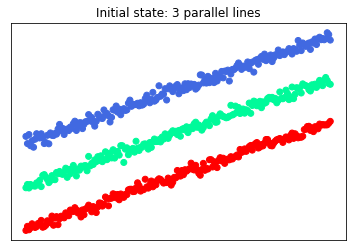

In [7]:
X, labs = t.make_parallel_lines(spacing = 40, num_lines = 3)
cdict = {1: 'red', 2: 'mediumspringgreen', 3: 'royalblue'}
plt.scatter(x = X[:, 0], y = X[:, 1], c = np.array(list(map(lambda x: cdict[x], labs))));
plt.title("Initial state: 3 parallel lines");
plt.xticks([]);
plt.yticks([]);
pass

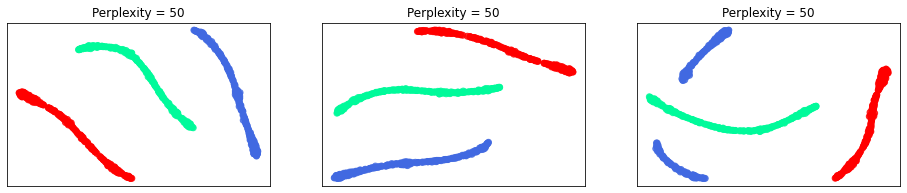

In [8]:
t.perp_plots(X = X, labs = labs, perp_vec = [50, 50, 50])

Next, we demonstrate how t-SNE performs across a range of perplexity values for four simple datasets: 

- Two clusters of 500-dimensional Gaussian data with equal variance (of which 2 dimensions are shown in the top row of the grid below)
- Two clusters of 500-dimensional Gaussian data with unequal variance (of which 2 dimensions are shown in the top row of the grid below)
- Two parallel lines with very little spacing between them
- Three parallel lines with moderate spacing, which are the same lines that were used in the demonstration above

From these examples, we can extract a few insights about the performance of t-SNE:

- Given a perplexity value that is appropriate for a given dataset, t-SNE appears to be quite proficient at preserving clusters (both for high dimensional and low dimensional starting points)
- Shape is not necessarily preserved through the t-SNE algorithm. For instance, t-SNE does not return two clusters of unequal size from the 500-dimensional Gaussians with unequal variance
- t-SNE has success across a wide range of perplexity values for groups that can be easily separated (e.g., the Gaussian blobs). For datasets with less discernable separation (e.g., two tight parallel lines), the choice of perplexity value is critical

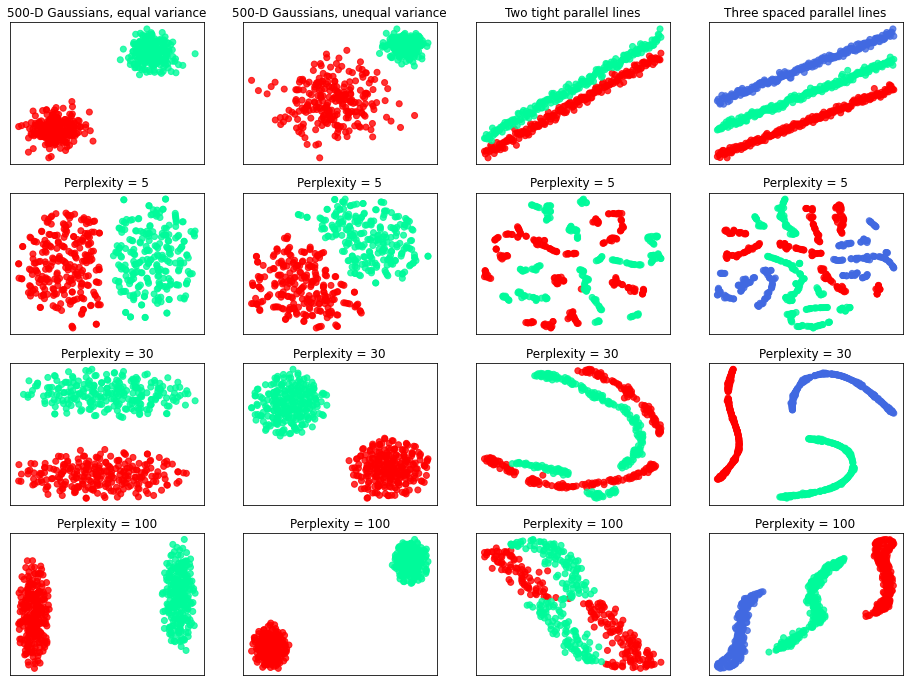

In [9]:
t.compare_plots(data_list = [t.make_two_blobs(), t.make_two_blobs(blob1_sd = 1.5), t.make_parallel_lines(), \
                              t.make_parallel_lines(spacing = 40, num_lines = 3)], \
                 title_list = ["500-D Gaussians, equal variance", \
                               "500-D Gaussians, unequal variance", \
                               "Two tight parallel lines", \
                              "Three spaced parallel lines"])

As the shapes considered above were quite simple, we also tested t-SNE on 3-dimensional objects with more complicated structures:

- Linked circles
- A trefoil knot
- Intertwined springs

While t-SNE is typically used for dimensionality reduction of high dimensional data, we chose more complicated structures in three dimensions due to ease of visualization. At low perplexity values, t-SNE does not perform well on these shapes. However, at moderate perplexity values, t-SNE appropriately flattens the 3-dimensional shapes into reasonable clusters, and at high perplexity values, more of the original structure is shown (e.g., the linking of the two circles)

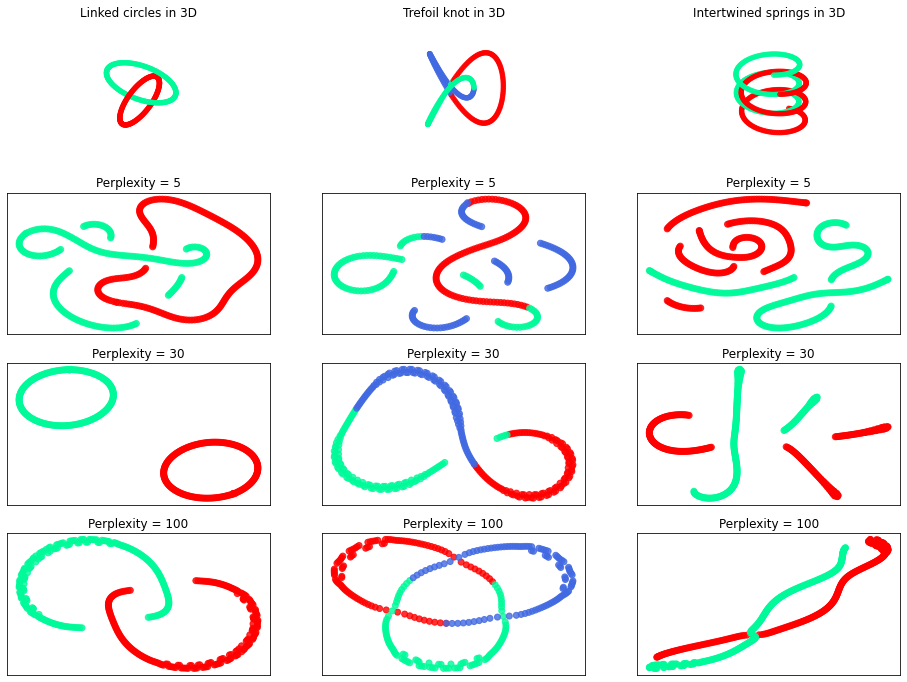

In [10]:
t.compare_plots(data_list = [t.make_two_3d_circles(), t.make_trefoil_knot(), t.make_springs()], \
                 title_list = ["Linked circles in 3D", \
                               "Trefoil knot in 3D", \
                               "Intertwined springs in 3D"], plot_3d = True)

Lastly, we were interested in studying the evolution of the t-SNE algorithm as a function of the iteration number. At least for the linked circles and trefoil knot, we still see evidence of t-SNE's random starting point at step 10, and then the appropriate shapes quickly begin to form. 

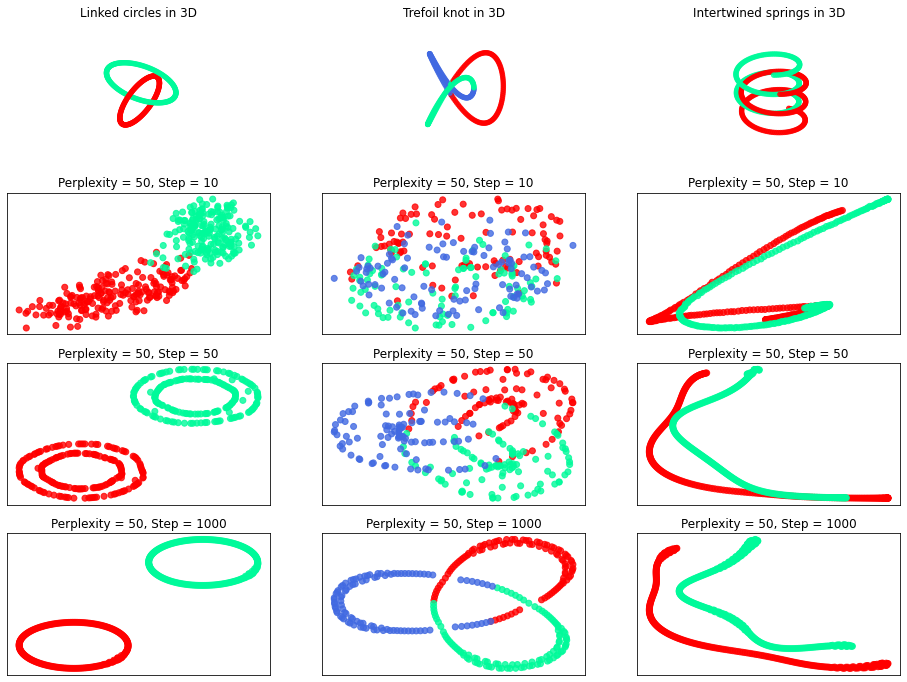

In [11]:
t.compare_plots(data_list = [t.make_two_3d_circles(), t.make_trefoil_knot(), t.make_springs()], \
                 title_list = ["Linked circles in 3D", \
                               "Trefoil knot in 3D", \
                               "Intertwined springs in 3D"], plot_3d = True, perp_plot = False, step_plot_perp = 50)

## Real Data and Comparisons [6, 7, 8, 9]

### Replicated Experiments

To evaluate t-SNE, the authors employ multiple experiments on canonical machine learning data sets and compare the results to alternative dimensionality reduction algorithms. The three principal data sets used are: (1) the MNIST digits data set, (2) the Olivetti faces data set, and (3) the COIL-20 data set. 

The MNIST digits data set contains 60,000 grayscale images of handwritten digits. The Olivetti data set contains images of 40 distinct subjects with various alterations to their photos. It should be noted that we use scikit-learn's "Olivetti faces" data set, which consists of 64x64 images rather than the original 92 x 112 images. Finally, the COIL-20 data set consists of 1,440 images of 20 different objects taken at different orientations. The images are 128x128 which differs from the 32x32 images originally described in "Visualizing Data using t-SNE."

![](data/plots/plot1.png)

The above plots illustrate the advantage of t-SNE. For each data set, we can identify distinct clusters associated with the different classes, with a few exceptions. The results on the COIL-20 and the Olivetti faces data sets are consistent with those of the original paper. For the Olivetti faces data set we see that distinct subjects are grouped together, except for a few that are split into separate clusters. As the authors state, this may result from significant variations in the different photos taken of the subject. Similarly, our t-SNE algorithm performs well on the COIL-20 data set and resembles the results from the original paper. Most objects are correctly clustered together with the one major exception being the three objects linked together in a parabola-like shape. This also occurred in the authors' experiment and was stated to correspond to photos of similar cars taken at the same orientation. When applying our t-SNE algorithm to the MNIST data set, there appear to be two groups of three digits that are tightly clustered together. The orange, aqua, and fuchsia cloud correspond to digits 3, 5, and 8 while the lime, deep pink, and brown cloud correspond to digits 9, 4, and 7. This differs from the well defined clusters in the original experiment. One explanation could be the randomly generated initial state, which we know leads to varying results upon different runs. Another reason could be the randomly selected digits. It is possible that our random sample contained larger variation across different photos for the same digit.

### External Data Sets  

Few disciplines utilize high-dimensional data as frequently as genomics. Gene sequencing technologies can generate thousands to hundreds of thousands of gene expressions. Thus, t-SNE can be a useful tool in genomics for exploring patterns and relationships between cells and individuals in a lower dimension.

For our experiment, we selected two data sets: (1) The Cancer Genome Atlas Pan-Cancer analysis project (PANCAN) and (2) Human M1 10x. The PANCAN data set consists of gene expression levels measured by the Illumina HiSeq platform from the tumors of individuals with different types of cancer. The data set we used was taken from the University of California, Irvine (UCI) Machine Learning Repository. It is a subset of the original data and contains the following types of cancer: Breast (BRCA), Colon (COAD), Kidney (KIRC), Lung (LUAD), Prostate (PRAD). There are 801 individuals included and 20531 measured gene expressions.

The Human M1 10x data set is provided by the Allen Institute for Brain Sciences. It includes single-nucleus transcriptomes taken from the primary visual cortex of two human brain specimens. Each row corresponds to a cell and each column corresponds to a gene. There were 50,281 genes sequenced. Due to computational resource limits, we take the first 2,000 rows of the data set as the entire data set is approximately 7GB. Our sample contains three broad cell classes: GABAergic, Non-neuronal, and Glutamatergic, and 16 cell subclasses. In the visualization, we use the distinct cell subclasses as labels.

![](data/plots/plot2.png)

As shown in the plots above, t-SNE is incredibly effective at clustering patients according to the type of cancerous tumor in the PANCAN data set. We acknowledge that this data set comes from UCI's machine learning repository and that the collection of gene expressions may have been selected for instructional purposes. With that being said, t-SNE performs reasonably well on the Human M1 10x data set. Many of the cell subclasses are correctly grouped with some of the groups split into two or three clusters. Some subclasses had a small sample size, which explains some of the various points spread across the image.

# Comparison to Competing Algorithms

In our comparative analysis, we selected Isomap and PCA as the reference alternative algorithms. For this experiment, we used their scikit-learn implementations. To maintain consistency with the original paper, when running the algorithms on the MNIST, COIL-20, and Olivetti faces data sets we use a perplexity value of 40 for t-SNE and 12 neighbors for Isomap. When running the algorithms on the PANCAN and Human M1 10x data sets, which are not present in our reference paper, we used a perplexity value of 30 for t-SNE and 20 neighbors for Isomap, as these parameters appeared to provide superior results.

## Comparison of accuracy

To compare the accuracy of the competing algorithms we observe their ability to cluster real data sets according to their class labels. We will restrict our comparison of the visualizations to the PANCAN and Human M1 10x data sets as the results from the other data sets resemble the original experiments included in the paper. Through observing, the different embeddings of the PANCAN data set Isomap appears to be just as effective as t-SNE in clustering the different types of cancerous tumors. While PCA was able to cluster patients with kidney cancer in one group all other samples join together as a single group. On the Human M1 10x, t-SNE outperforms the other methods. While Isomap demonstrates some ability to capture the different classes, they are all concentrated together and not as clearly distinguished as the t-SNE clustering. PCA fails to cluster any of the classes as all samples are merged together. From this analysis the utility of t-SNE is apparent. It can capture high-dimensional patterns in a two-dimensional setting and has shown to produce improved embeddings when compared to Isomap and PCA.

## Comparison of speed

We compare runtimes of t-SNE, PCA, and Isomap when applied to 1000 randomly selected samples of the MNIST dataset. We use 1000 iterations for t-SNE,  the same number of iterations used in our accuracy comparisons and the original paper.

In [12]:
Xm, ym = util.load_mnist(size=1000)
isomap = Isomap(n_neighbors=12, n_components=2)

In [13]:
print("t-SNE run time")
%timeit t.tsne(Xm, niter=1000, verbose=False)

print("PCA run time")
%timeit t.pca(Xm, k=2)

print("Isomap run time")
%time x=isomap.fit_transform(Xm)

t-SNE run time
1min ± 4.26 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
PCA run time
23 ms ± 607 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Isomap run time
CPU times: user 1.91 s, sys: 7.88 ms, total: 1.92 s
Wall time: 833 ms


PCA is the fastest of the three methods, and both PCA and Isomap are significantly faster than t-SNE. The differences in runtime are explained by the following: 
         
- PCA uses greedy low-rank matrix approximations which are fast.
- Isomap finds pairwise distances before doing a greedy low-rank matrix approximation
- t-SNE iteratively solves an objective, each step of which requires pairwise distances. 
             
Thus to obtain the improved embeddings that t-SNE offers requires a significant sacrifice in computational time.

# Discussion

The t-distributed stochastic neighbor embedding (t-SNE) algorithm is a widely used nonlinear dimensionality reduction method for embedding high-dimensional data in a low-dimensional space. It excels at recovering a natural grouping in a  low-dimensional space, which often can be visualized as well-defined clusters. However, it comes with a few limitations. Independent runs of t-SNE lead to variable results and resulting clusters are highly sensitive to initial parameter choices. Therefore, when using t-SNE one should validate results with multiple runs and different initial parameter choices. Another limitation is the increase in computational time relative to competing algorithms. Its ability to produce superior clusters, when compared to PCA and Isomap, came with a dramatic increase in runtime. Even with these limitations, t-SNE is a valuable data visualization tool for any field that requires working with high-dimensional data.

# Contributions

Overall, we all feel that this project has been a positive team experience and that all team members have contributed approximately equally. Initially, we all read the "Visualizing High-Dimensional Data Using t-SNE" paper and created three separate working versions of the algorithm. We then came together and pooled the best functions from our original versions, and there is no clear division or attibution for the main body of the code. 

Throughout the project, we frequently collaborated with each other and asked questions to ensure that team members felt supported and were not overburdened with work. That said, for the report, each of us took ownership over distinct parts, which are listed below:

- Steven wrote the sections entitled `Background`, `Description of Algorithm`, and `Optimization`. Steven is also responsible for optimizing our code beyond the original pooled version and writing the code for the benchmarking. Lastly, Steven contributed to writing unit tests

- Rob wrote all code and interpretations for the `Applications to Simulated Data` section of the report. Rob also contibuted to writing unit tests, published the package, created the `Makefile`, and documented references

- Marc wrote all code and interpretations for the `Real Data and Comparisons` and `Discussion` sections of the report. Marc also contibuted to writing unit tests and testing the `Makefile`

All team members were responsible for reading and copy-editing the report in its entirety.

# Installation

This package (`tsne663`) can be installed from [TestPyPI](https://test.pypi.org/project/tsne663/1.0/) using `pip install -i https://test.pypi.org/simple/ tsne663==1.0`. Alternatively, one can navigate to the [Github repository](https://github.com/robkravec/STA663_Project) and run `python setup.py install`. 

Upon installation, the following prerequisites will also be installed (versions shown are those used during development), which ensures that the package will work properly:

- `matplotlib` - 3.1.1
- `numpy` - 1.18.1
- `numba` - 0.48.0
- `tqdm` - 4.42.0
- `sklearn` - 0.22.1

Two additional packages, while not automatically installed, are necessary to reproduce the results from the simulations:

- `plotly` - 4.5.0
- `textwrap` - 3.9.4

# References

\[1\] L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. Journal of Machine Learning Research 9(Nov):2579-2605, 2008.

\[2\] Vin de Silva and Joshua B. Tenenbaum. Global Versus Local Methods in Nonlinear Dimensionality Reduction. Proccedings of the 15th International Convference on Neural Information Processing Systems. Jan 2002.


\[3\] Dmitry Kobak, George Linderman, Stefan Steinerberger, Yuval Kluger, and Philipp Berens. Heavy-tailed Kernels Reveal a Finer Cluster Structure in t-SNE Visualisations. ECML PKDD 2019. doi: 10.1007/978-3-030-46150-8_8

\[4\] L.J.P. van der Maaten. Apr 2021. https://lvdmaaten.github.io/tsne/.

\[5\] Wattenberg, et al., "How to Use t-SNE Effectively", Distill, 2016. http://doi.org/10.23915/distill.00002

\[6\] Yann LeCun, Corinna Cortes, and Christopher J.C. Burges. The MNIST Database. Apr 2021. http://yann.lecun.com/exdb/mnist/.

\[7\] UCI Machine Learning Respository. Gene expression Cancer RNA-seq Data Set. Jun 2016. https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#.

\[8\] Allen Institute for Brain Science. Human M1 10x. Apr 2021. https://portal.brain-map.org/atlases-and-data/rnaseq/human-m1-10x.

\[9\] "Columbia Object Image Library (COIL-20)," S. A. Nene, S. K. Nayar and H. Murase, Technical Report CUCS-005-96, February 1996.